In [1]:
import json 
import pandas as pd 
import csv
from pandas import json_normalize
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import string
import re
import nltk
import ssl
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from pyvis.network import Network
from tqdm import tqdm
from IPython.display import IFrame

Matplotlib is building the font cache; this may take a moment.


## Load Data

In [2]:
# Load JSON Lines file into DataFrame
df = pd.read_json('data_and_files/random_tweets.json', lines=True)

# Function to extract user mentions as a comma-separated string
def extract_user_mentions(user_mentions):
    if isinstance(user_mentions, list):
        return ','.join([mention['screen_name'] for mention in user_mentions])
    return ''

# Function to extract URLs as a comma-separated string
def extract_urls(urls):
    if isinstance(urls, list):
        return ','.join([url['url'] for url in urls])
    return ''

# Function to extract hashtags as a comma-separated string
def extract_hashtags(hashtags):
    if isinstance(hashtags, list):
        return ','.join([hashtag['text'] for hashtag in hashtags])
    return ''

# Flatten fields for each tweet
df['user_mentions'] = df['entities'].apply(lambda x: extract_user_mentions(x.get('user_mentions', [])))
df['urls'] = df['entities'].apply(lambda x: extract_urls(x.get('urls', [])))
df['hashtags'] = df['entities'].apply(lambda x: extract_hashtags(x.get('hashtags', [])))
df['text'] = df['text']  # Directly take 'text' as it is

# Select only the required columns
df = df[['text', 'user_mentions', 'urls', 'hashtags']]

# Display the DataFrame with the required fields
print(df.head())

#send to csv
df.to_csv('raw_data.csv')

                                                text    user_mentions urls  \
0  RT @KWWLStormTrack7: We are more than a month ...  KWWLStormTrack7        
1  @hail_ee23 Thanks love its just the feeling of...        hail_ee23        
2  RT @TransMediaWatch: Pink News has more on the...  TransMediaWatch        
3  RT @realDonaldTrump: One of the reasons we nee...  realDonaldTrump        
4  RT @First5App: This hearing of His Word doesn’...        First5App        

  hashtags  
0           
1           
2           
3           
4           


## Explore 

In [3]:
# Keywords to search for
keywords = ["twitter", "tweet", "retweet"]

# Combine keywords into a single regex pattern
pattern = '|'.join(keywords)

# Filter the DataFrame
filtered_df = df[df['text'].str.contains(pattern, case=False, na=False)]

# Display the filtered DataFrame
print(filtered_df)

# Send to csv 
filtered_df.to_csv('filtered_raw_data.csv')

                                                    text  \
18     RT @taegislut_: filo armys;\n\nwith every rt o...   
91     RT @magi_jay: I can see the headlines &amp; tw...   
97     RT @IamRajii: Sorry that I disturbed the threa...   
113    RT @MattyCoversATS: Retweet for my top-graded ...   
213    RT @jonskeet: Given the slew of recent "I made...   
...                                                  ...   
10760  RT @MayWardJedi: I tweeted this last month bef...   
10828  RT @TrendsOfNigeria: Missing Original NYSC cer...   
10857  I'm so upset I dropped the word "can" when dra...   
10932  RT @sean_spicier: All these liberals tweeting ...   
10945  RT @xchaereign: CL DESERVES BETTER. THAT'S IT....   

                user_mentions                     urls  hashtags  
18                 taegislut_                                     
91                   magi_jay                                     
97                   IamRajii  https://t.co/0MvwVscA8G            
113        

## Convert

In [4]:
df_embed = pd.read_csv('filtered_raw_data.csv')

### Load Pre-trained Embedding Models

In [5]:
# Load pre-trained model tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


### Create nodes

In [6]:
# Extract hashtags from text
df_embed['hashtags'] = df_embed['text'].apply(lambda x: re.findall(r"#(\w+)", x))

# For simplicity, we'll consider topics as unique words (excluding mentions and hashtags)
df_embed['topics'] = df_embed['text'].apply(lambda x: re.findall(r"\b(?!@|#)\w+\b", x.lower()))

# Combine all unique nodes (users, hashtags, topics)
nodes = set(df_embed['user_mentions']).union(*df_embed['hashtags']).union(*df_embed['topics'])


### Tokenize and convert to vector space using pre-trained model

In [7]:
# Function to get embeddings for a single text
def get_embeddings(text):
    """Get embeddings for a single text."""
    if not isinstance(text, str):
        return np.zeros((1, model.config.hidden_size))  # Return a zero vector if text is not a string
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    return last_hidden_state.mean(dim=1).detach().numpy()

# Generate embeddings for each node
node_embeddings = {node: get_embeddings(node) for node in nodes}

### Visualize the vector space 

In [8]:
# Convert the dictionary of embeddings to a list of embeddings and a list of corresponding nodes
embeddings_list = []
nodes_list = []

for node, embedding in node_embeddings.items():
    embeddings_list.append(embedding.flatten())  # Flatten the embedding to a 1D array
    nodes_list.append(node)

# Convert to numpy array
embeddings_np = np.vstack(embeddings_list)

In [9]:
# Reduce dimensions with PCA first
pca = PCA(n_components=50)  # Reduce to 50 dimensions
pca_result = pca.fit_transform(embeddings_np)

# Further reduce to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Glyph.*missing from current font.")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21619 (\N{CJK UNIFIED IDEOGRAPH-5473}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Pyth

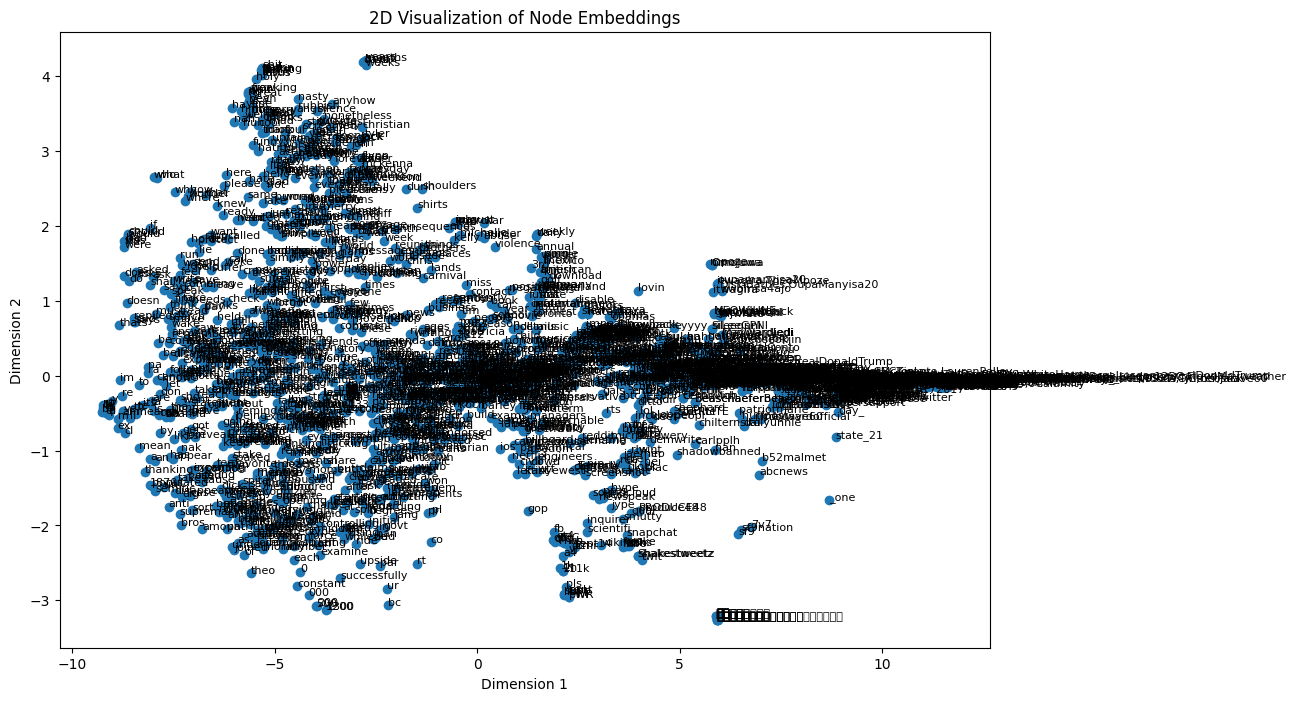

In [11]:
# Create a DataFrame for easy plotting
df_embeddings = pd.DataFrame(tsne_result, columns=['x', 'y'])
df_embeddings['node'] = nodes_list

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(df_embeddings['x'], df_embeddings['y'])

# Annotate points
for i, txt in enumerate(df_embeddings['node']):
    plt.annotate(txt, (df_embeddings['x'][i], df_embeddings['y'][i]), fontsize=8)

plt.title('2D Visualization of Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Find semantically similar nodes

In [12]:
# Ensure node embeddings are 2D: (num_nodes, embedding_dim)
node_list = list(node_embeddings.keys())
embeddings = [node_embeddings[node].flatten() for node in node_list]  # Flatten embeddings to 1D

# Check shape
print(f"Shape of individual embedding: {embeddings[0].shape}")
print(f"Total number of embeddings: {len(embeddings)}")

# Convert list of 1D embeddings into a 2D numpy array
embedding_matrix = np.vstack(embeddings)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(embedding_matrix)

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=node_list, columns=node_list)
print(similarity_df)


Shape of individual embedding: (768,)
Total number of embeddings: 2020
                     1300      till     bukan     kelly  witnessed  \
1300             1.000000  0.751904  0.490894  0.733066   0.790870   
till             0.751904  1.000000  0.521553  0.786863   0.826026   
bukan            0.490894  0.521553  1.000000  0.570462   0.539068   
kelly            0.733066  0.786863  0.570462  1.000000   0.785147   
witnessed        0.790870  0.826026  0.539068  0.785147   1.000000   
...                   ...       ...       ...       ...        ...   
sumod            0.633631  0.605035  0.467002  0.650336   0.665898   
experts          0.784692  0.800370  0.573924  0.852769   0.825147   
realDonaldTrump  0.469010  0.467767  0.363131  0.519567   0.510358   
scientifi        0.320869  0.304813  0.240349  0.296146   0.307808   
tay              0.784664  0.834763  0.571886  0.869678   0.817655   

                 LionelMedia,therealroseanne  productions  presidency  \
1300           

### Create edges between nodes

In [13]:
# Define a similarity threshold for creating edges
similarity_threshold = 0.90

# Initialize the graph
G = nx.Graph()

# Add edges based on similarity threshold
for i, node1 in enumerate(node_list):
    for j, node2 in enumerate(node_list):
        if i != j and similarity_df.loc[node1, node2] > similarity_threshold:
            G.add_edge(node1, node2, weight=similarity_df.loc[node1, node2])

# Display the graph info
print(nx.info(G))

Graph with 1022 nodes and 12355 edges


/var/folders/6d/czkd7b150tj6bnjxj5l6fz3r0000gn/T/ipykernel_5570/1062181525.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


### Visualize the network graph

In [14]:
# Create a Pyvis network
net = Network(notebook=True, height='800px', width='100%', bgcolor='#222222', font_color='white')

# Add nodes with a progress bar
print("Adding nodes...")
for node in tqdm(G.nodes(), desc="Adding Nodes"):
    net.add_node(node, label=node)

# Add edges with a progress bar
print("Adding edges...")
for edge in tqdm(G.edges(data=True), desc="Adding Edges"):
    net.add_edge(edge[0], edge[1], weight=edge[2]['weight'])

# Set the physics layout
print("Applying layout...")
net.force_atlas_2based()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Adding nodes...


Adding Nodes: 100%|██████████████████████| 1022/1022 [00:00<00:00, 86655.32it/s]


Adding edges...


Adding Edges: 100%|█████████████████████| 12355/12355 [00:05<00:00, 2397.15it/s]

Applying layout...


In [15]:
# Show the interactive network
print("Generating interactive network...")
net.show("network_graph_interactive.html")
print("Interactive network saved to network_graph_interactive.html")

Generating interactive network...
network_graph_interactive.html
Interactive network saved to network_graph_interactive.html


In [16]:
IFrame(src='network_graph_interactive.html', width=800, height=600)